In [46]:
import os

import pandas as pd

import json
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
timing_dir = '../eval/tabular_performance'
files = [os.path.abspath(os.path.join(timing_dir, f)) for f in os.listdir(timing_dir) if ('.json' in f)]
# files

In [48]:
files = [f for f in files if 'intratc' in f]# and ('5|512' in f or '3|256' in f)]
files

['/u/antor/u13/ukumaras/Projects/mldb/eval/tabular_performance/opt_vec_onnx_dnn|3|256_iris_n_10000000_bs_256_run_3_intratc_2.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/tabular_performance/opt_vec_onnx_dnn|5|512_iris_n_10000000_bs_1024_run_3_intratc_4.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/tabular_performance/opt_vec_onnx_dnn|3|256_iris_n_10000000_bs_1024_run_2_intratc_192.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/tabular_performance/opt_vec_onnx_dnn|1|128_iris_n_10000000_bs_1024_run_2_intratc_8.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/tabular_performance/opt_vec_onnx_dnn|7|1024_iris_n_10000000_bs_1024_run_1_intratc_192.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/tabular_performance/opt_vec_onnx_dnn|3|256_iris_n_10000000_bs_64_run_1_intratc_16.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/tabular_performance/opt_vec_onnx_dnn|1|128_iris_n_10000000_bs_4096_run_3_intratc_1.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/tabular_performance/opt

In [49]:
results = []

for file in files:
    with open(file, "r") as f:
        name = file.split("/")[-1].split(".")[0]
        meta_raw = name.split("_iris_")[1].split("_")
        keys = meta_raw[0::2]
        values = meta_raw[1::2]

        meta = {k: int(v) for k, v in zip(keys, values)}
        model = name.split('dnn')[1].split("_")[0]
        model = "|1|128" if (model == "") else model
        meta['model'] = model
        
        content = json.loads(f.read())
        prediction = content['children'][0]['children'][0]
        pred_info = prediction['extra_info'].split('|')[1:]
        total = 0
        for i in pred_info:
            kv = i.split(":")
            if (kv[0] in ['load', 'move', 'predict', 'move_rev']):
                total += int(kv[1])
            meta[kv[0]] = int(kv[1])
        meta['total_time'] = total / (1000 * 1000)
        meta['acc'] = float(meta['correct']) / meta['total']
        results.append(meta)

results = pd.DataFrame(results)
results

,n,bs,run,intratc,model,correct,load,move,move_rev,predict,total,total_time,acc
0,10000000,256,3,2,|3|256,3333845,48425,706057,282172,30769982,10000000,31.806636,0.333384
1,10000000,1024,3,4,|5|512,3333670,59131,494581,204599,58155667,10000000,58.913978,0.333367
2,10000000,1024,2,192,|3|256,3333845,178014,533696,210307,18703356,10000000,19.625373,0.333384
3,10000000,1024,2,8,|1|128,3333362,43605,446204,151943,6264319,10000000,6.906071,0.333336
4,10000000,1024,1,192,|7|1024,3335908,386829,614774,340164,410109627,10000000,411.451394,0.333591
...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,10000000,2048,3,8,|1|128,3333362,46509,391798,144370,3136435,10000000,3.719112,0.333336
653,10000000,64,2,1,|7|1024,3335908,109913,2133288,1107154,2028877915,10000000,2032.228270,0.333591
654,10000000,2048,1,64,|7|1024,3335908,255196,620165,269610,515714592,10000000,516.859563,0.333591
655,10000000,4096,1,128,|1|128,3333362,129970,318576,133548,3367645,10000000,3.949739,0.333336


## Batch Size vs Intra Thread Count

In [50]:
out = results
out = out.loc[:, ['bs', 'intratc', 'model', 'total_time']]#.groupby(['bs', 'intratc', 'model']).mean().reset_index()

model_map = {
    '|1|128': "Small (hidden layers: 1, dimention: 128)",
    '|3|256': "Medium (hidden layers: 3, dimention: 256)",
    '|5|512': "Large (hidden layers: 5, dimention: 512)",
    '|7|1024': "Very Large (hidden layers: 7, dimention: 1024)",
}
out['model'] = out['model'].apply(lambda x: model_map[x])

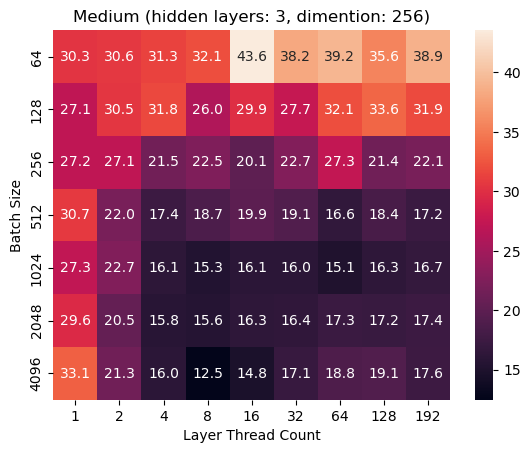

Index([64, 128, 256, 512, 1024, 2048, 4096], dtype='int64', name='bs')


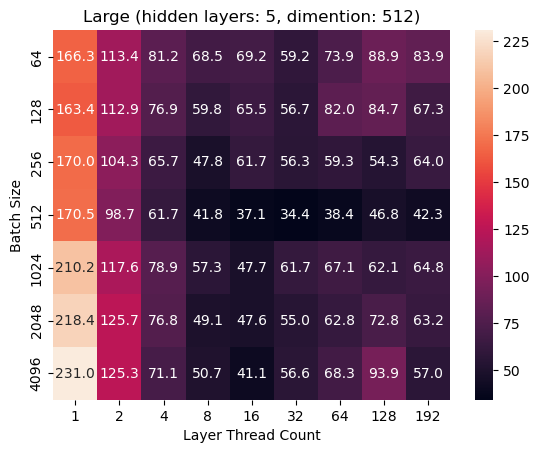

Index([64, 128, 256, 512, 1024, 2048, 4096], dtype='int64', name='bs')


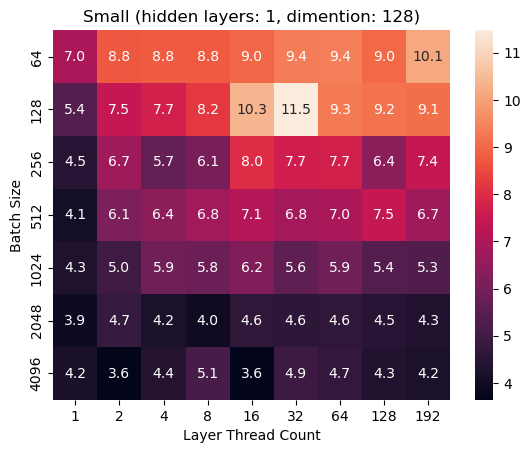

Index([64, 128, 256, 512, 1024, 2048, 4096], dtype='int64', name='bs')


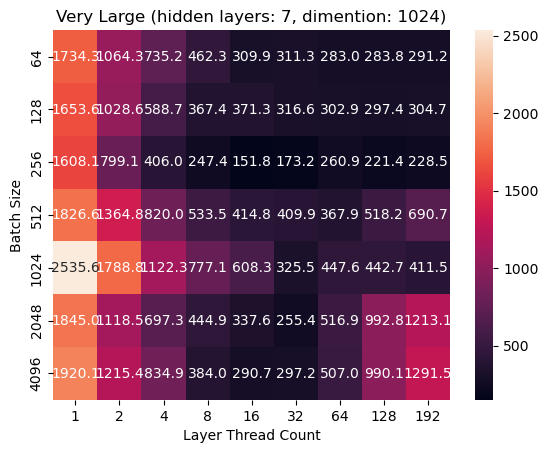

Index([64, 128, 256, 512, 1024, 2048, 4096], dtype='int64', name='bs')


In [52]:
import plotly.graph_objects as go

def show_plotly(df):
    print(df.index)
    fig = go.Figure(data =
        go.Contour(
            z=df.values,
            x=df.columns, # horizontal axis
            y=df.index # vertical axis
        ))
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
    fig.show()

def show_plt(df):
    plt.figure()
    sns.heatmap(data=df, annot=True, fmt=".1f")
    plt.xlabel("Layer Thread Count")
    plt.ylabel("Batch Size")
    plt.title(model)
    plt.show()
    
for model in out['model'].drop_duplicates().values:
    # plt.figure()
    df = out[out['model'] == model]
    df = df.loc[:, ['bs', 'intratc', 'total_time']].groupby(['bs', 'intratc']).mean().reset_index()
    df = df.pivot(index="bs", columns="intratc", values="total_time")
    show_plt(df)
    show_plotly(df)
    